# MNIST - Introduction

The MNIST is a large handwritten digit dataset commonly used to train various image processing systems. In this project I apply a few techniques to train a eficient machine learnin model to create a submission for [kaggle competition](https://www.kaggle.com/competitions/digit-recognizer).
The objective is to perform few techniques and algorithms such as PCA for dimensionality reduction and an ensemble classification algorithm. I will also try some digits that I handwrote myself in the final model.
___

## Data Understanding

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#this func gets a file path, it will be very useful to browse directories
def get_file_path(file, dir_name):
    project_dir = os.path.dirname(os.path.dirname(os.path.abspath("-")))
    data_dir = os.path.join(project_dir, dir_name)
    file_path = os.path.join(data_dir, file)
    return file_path
    
file_path = get_file_path("train.csv", "original data")

In [3]:
df = pd.read_csv(file_path)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = df.drop(["label"], axis = 1).values
y = df["label"].values

In [5]:
 X.shape, y.shape

((42000, 784), (42000,))

Each feature of the dataset is a pixel, and there are 42000 instances, we'll may have a problem with memory to mess with this dataset.
Since they are images it is possible to visualize them. Let's see some exemples:

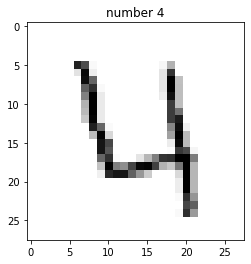

In [6]:
plt.imshow(X[3].reshape(28,28), cmap = mpl.cm.binary)
plt.title("number "+str(y[3]))
plt.show()

It was necessary to reshape X[3] to convert the array of pixels into a matrix so that it could be visualized.

## Data Preparation
First let's scale the data before peform a  Principal Component Analisys.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(42000, 320)

Great!
With PCA it was possible to reduce  the number of features from 784 to 320 preserving 95% of the information(variance). Let's now start modeling.
___

## Modeling
I will now build a Pipeline with the data preparation steps.

Three algorithms are going to be used: KNN, LogisticRegression and RandomForestClassifier. 
They'll be validated using k-fold cross validation.

In [45]:
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score


In [47]:

pipeline_knn = Pipeline(steps=[
    ("scaler", scaler),
    ("pca", pca),
    ("model", KNeighborsClassifier( n_neighbors=10, n_jobs=-1))
])

scores = cross_val_score(pipeline_knn,X,y,scoring='accuracy',cv=3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Accuracy: 0.935 (0.001)


In [18]:
pipeline_lr = Pipeline(steps=[
    ("scaler", scaler),
    ("pca", pca),
    ("model", LogisticRegression(multi_class="multinomial",solver="lbfgs", C=1, max_iter=1000))
])

scores = cross_val_score(pipeline_lr,X,y,scoring='accuracy',cv=3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.916 (0.001)


In [20]:
pipeline_rf = Pipeline(steps=[
    ("scaler", scaler),
    ("pca", pca),
    ("model", RandomForestClassifier(max_depth=300))
])

scores = cross_val_score(pipeline_rf,X,y,scoring='accuracy',cv=3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.928 (0.001)


We'll also train two ensemble models, with voting *soft* (uses the probabilities) and *hard*(uses the classification).

In [49]:
from sklearn.ensemble import VotingClassifier

voting_clf_soft = VotingClassifier(
estimators=[('SVC', pipeline_knn), 
('LogisticRegression', pipeline_lr), 
('Forest', pipeline_rf)],
voting='soft')

scores = cross_val_score(voting_clf_soft,X,y,scoring='accuracy',cv=3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.944 (0.001)


In [48]:
voting_clf_hard = VotingClassifier(
estimators=[('SVC', pipeline_knn), 
('LogisticRegression', pipeline_lr), 
('Forest', pipeline_rf)],
voting='hard')

scores = cross_val_score(voting_clf_hard,X,y,scoring='accuracy',cv=3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.938 (0.001)


## Submissions
Once all models are avaliated with cross validation we can start to work on the submissions to kaggle competition.

In [39]:
def create_submission(model, filename):
    test_path = get_file_path("test.csv", "original data")
    df_test = pd.read_csv(test_path)
    X_test = df_test.values
    yhat = model.predict(X_test)

    imageid = [i for i in range(1,df_test.shape[0]+1)]
    dic_sub={"ImageId":imageid,"Label":yhat}    

    df_submission = pd.DataFrame(dic_sub)
    submission_path = os.path.join(get_file_path("", "submissions"),filename)
    df_submission.to_csv(submission_path, index = False)

In [ ]:
#fitting all models
pipeline_knn.fit(X,y)
pipeline_lr.fit(X,y)
pipeline_rf.fit(X,y)
voting_clf_soft.fit(X,y)
voting_clf_hard.fit(X,y)

In [40]:
#creating the submissions
create_submission(pipeline_knn,"knn_submission.csv")
create_submission(pipeline_lr,"LogisticiRegression_submission.csv")
create_submission(pipeline_rf,"RandomForestClassifier_submission.csv")
create_submission(voting_clf_soft,"ensemble_soft_submission.csv")
create_submission(voting_clf_hard,"ensemble_hard_submission.csv")

I got around 80% of accuracy with these models when they were submitted to kaggle. Let's try another model without apllying dimensionality reduction.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = Pipeline(steps=[("scaler",StandardScaler()), 
                        ("rand forest", RandomForestClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

model.fit(X_train, y_train)
yhat = model.predict(X_test)
print("Accuracy = ",accuracy_score(y_test, yhat))

Accuracy =  0.9626984126984127


This model got 96.5% of accuracy!
This can indicate that the dimensionality reduction is causing information loss, or the models are not complex enough to improve the predictions. 
Note that it is very hard to tune the hyperparameters with scikitlearn in this dataset since it has a lot of features and instances. It takes too long to train and predict(and also a lot of memory), perhaps the best approach is to find another framework capable of handling it better.
___

## Bonus!

Now lets try some instances that I handwrote in a paper and digitaly and see if the model can classify them.

In [94]:
#This loads the images from the imgtest folder
from PIL import Image
import PIL.ImageOps 

imgs = []
for i in range(10):
    str_file = "img"+str(i)+".jpg"
    file_name = get_file_path(str_file, "imgtest")
    file = Image.open(file_name)
    imgs.append((file))


 
pixel_list = [np.array(img)[:,:,0] for img in imgs] # converts the img to array numpy(pixels)


Note that all images were prepared before being loaded, i.e. they were made 28x28

In [100]:
#reshaping the array to create 784 features (28x28)
reshaped_pixels = [pixel_matrix.reshape(784) for pixel_matrix in pixel_list ]
input_data = pd.DataFrame(reshaped_pixels)
input_data.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-2,-1,-2,-1,-1,-3,-1,-1,-2,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-2,-2,-3,-1,-2,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-2,-3,-1,-1,-2,-1,-1,-1,...,-3,-1,-1,-1,-1,-2,-1,-1,-1,-1
4,-1,-1,-1,-1,-3,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [101]:
X_input = input_data.values  #features
y_input = np.array([1,2,3,4,5,6,7,1,2,3]) #labels
model.fit(X,y) #fitting with all avaliable data
yhat_input = model.predict(X_input)
print("Accuracy:", accuracy_score(y_input, yhat_input))
print(y_input, "<- labels") 
print(yhat_input, "<- predictions")

Accuracy: 0.6
[1 2 3 4 5 6 7 1 2 3] <- labels
[4 2 3 4 5 3 7 1 1 1] <- predictions
